##### Name: Kavya Gengedulla Yeranarasappa
##### Github username: kavyagy
##### USC ID: 3206274199


In [1]:
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from scipy.stats import mode
import numpy as np
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from skimage.measure import block_reduce
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

## 1a) Reading the IEMOCAP dataset and extractign the labels

In [2]:
dataset = pd.read_csv('dataset.csv')
print(dataset.shape)

(1336, 6)


In [3]:
# Extract features and labels
base_directory = '.'

# Load visual features
X_visual = np.array([np.load(base_directory + fp) for fp in dataset['visual_features']], dtype="object")

# Load acoustic features
X_audio = np.array([np.load(base_directory + fp) for fp in dataset['acoustic_features']], dtype="object")

# Load lexical features
X_text = np.array([np.load(base_directory + fp) for fp in dataset['lexical_features']], dtype="object")

# Extract labels
y = dataset['emotion_labels']

print(X_visual.shape)
print(X_audio.shape)
print(X_text.shape)
print(y.shape)

(1336,)
(1336,)
(1336, 768)
(1336,)


## 1b) Applying mean pooling to audio and visual

In [4]:
def apply_mean_pooling(array):
    pooled = np.mean(array, axis=0)
    return pooled

# Apply mean pooling to each array in X_audio and X_video
X_visual_pooled = np.array([apply_mean_pooling(inner_array) for inner_array in X_visual])
X_audio_pooled = np.array([apply_mean_pooling(inner_array) for inner_array in X_audio])


print("Result of mean pooling for X_video:")
print(X_visual_pooled)
print("Result of mean pooling for X_audio:")
print(X_audio_pooled)
print("Result of  X_text:")
print(X_text)

Result of mean pooling for X_video:
[[-0.02337928 -0.23789907 -0.04487504 ... -0.02086512 -0.0458353
  -0.10953884]
 [-0.17260942  0.11016683 -0.15991506 ...  0.01192388  0.10901881
  -0.02703263]
 [ 0.20136312 -0.1200087   0.45775919 ...  0.42663874 -0.07298875
   0.00669748]
 ...
 [ 0.34154055  0.64742594  0.67713938 ...  0.07752116  0.75052153
   0.14769751]
 [-0.08008353 -0.06432546  0.37009722 ... -0.30255509  0.08057786
  -0.14496143]
 [ 0.28249418  0.05505693  0.1557793  ...  0.10584674 -0.0954645
   0.48159406]]
Result of mean pooling for X_audio:
[[-0.02412775  1.3312446  -1.0692344  ... -0.01661444  0.4902663
  -0.48119876]
 [ 0.         -0.49074307  0.06893975 ...  0.         -0.77385956
   0.5741296 ]
 [-0.02412775  1.463616    0.14719118 ... -0.01661444  0.7832034
   0.7766514 ]
 ...
 [-0.02112799 -0.57605493 -0.3768546  ... -0.01357803  0.6162509
  -0.31210086]
 [-0.02112799 -0.6948027   0.08765702 ... -0.01357803 -0.06176093
  -0.38913798]
 [-0.02112799 -0.6948027  -1.29

##  1c) Performing classification using svc and random forest 

In [5]:
# Split the dataset into training and testing sets for each modality
X_visual_train, X_visual_test, y_train, y_test = train_test_split(X_visual_pooled, y, test_size=0.2, random_state=42)
X_audio_train, X_audio_test, _, _ = train_test_split(X_audio_pooled, y, test_size=0.2, random_state=42)
X_text_train, X_text_test, _, _ = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Define oversampling strategy
oversampler = RandomOverSampler(random_state=42)

# Oversample the training data for each modality
X_visual_train_resampled, y_train_resampled = oversampler.fit_resample(X_visual_train, y_train)
X_audio_train_resampled, _ = oversampler.fit_resample(X_audio_train, y_train)
X_text_train_resampled, _ = oversampler.fit_resample(X_text_train, y_train)

# Define classifiers for each modality
visual_classifier = SVC()
audio_classifier = RandomForestClassifier()
text_classifier = SVC()

# Define hyperparameter grids for each classifier
param_grid_visual = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

param_grid_audio = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20]
}

param_grid_text = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform Grid Search for each classifier
grid_search_visual = GridSearchCV(visual_classifier, param_grid_visual, cv=5, scoring='f1_micro')
grid_search_visual.fit(X_visual_train_resampled, y_train_resampled)

grid_search_audio = GridSearchCV(audio_classifier, param_grid_audio, cv=5, scoring='f1_micro')
grid_search_audio.fit(X_audio_train_resampled, y_train_resampled)

grid_search_text = GridSearchCV(text_classifier, param_grid_text, cv=5, scoring='f1_micro')
grid_search_text.fit(X_text_train_resampled, y_train_resampled)

# Evaluate each classifier using cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

visual_cv_scores = cross_val_score(grid_search_visual.best_estimator_, X_visual_test, y_test, cv=skf, scoring='f1_micro')
audio_cv_scores = cross_val_score(grid_search_audio.best_estimator_, X_audio_test, y_test, cv=skf, scoring='f1_micro')
text_cv_scores = cross_val_score(grid_search_text.best_estimator_, X_text_test, y_test, cv=skf, scoring='f1_micro')

# Report results
print("F1-micro for Visual Modality:", visual_cv_scores.mean())
print("F1-micro for Audio Modality:", audio_cv_scores.mean())
print("F1-micro for Text Modality:", text_cv_scores.mean())

F1-micro for Visual Modality: 0.47742837176799446
F1-micro for Audio Modality: 0.5785464709993012
F1-micro for Text Modality: 0.4851153039832285


## 2a)
**Observations:** 
> To handle the problem of class imbalance, several techniques can be applied. In the above code, the *RandomOverSampler* from the imbalanced-learn library is used to address class imbalance. This technique oversamples the minority class by creating duplicates of its samples until the classes are balanced. 

## 2b) Plotting confusion matrix below for the four different classes

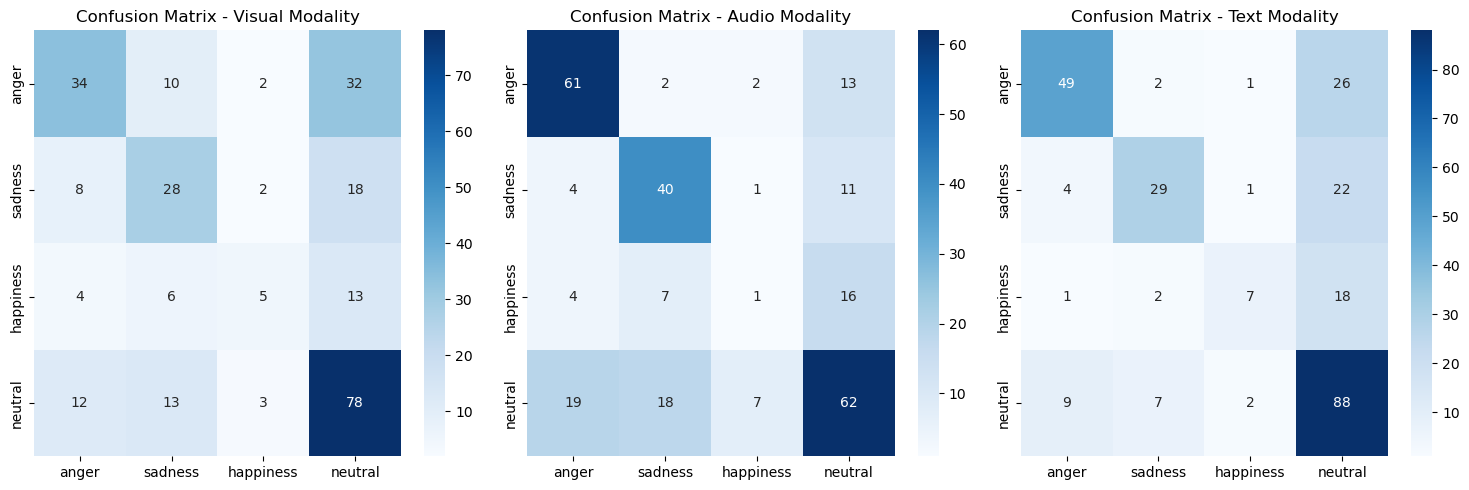

In [6]:
# Plot confusion matrix for each modality
plt.figure(figsize=(15, 5))

# Visual Modality
plt.subplot(1, 3, 1)
y_pred_visual = grid_search_visual.best_estimator_.predict(X_visual_test)
conf_mat_visual = confusion_matrix(y_test, y_pred_visual)
sns.heatmap(conf_mat_visual, annot=True, fmt='d', cmap='Blues', xticklabels=['anger', 'sadness', 'happiness', 'neutral'], yticklabels=['anger', 'sadness', 'happiness', 'neutral'])
plt.title('Confusion Matrix - Visual Modality')

# Audio Modality
plt.subplot(1, 3, 2)
y_pred_audio = grid_search_audio.best_estimator_.predict(X_audio_test)
conf_mat_audio = confusion_matrix(y_test, y_pred_audio)
sns.heatmap(conf_mat_audio, annot=True, fmt='d', cmap='Blues', xticklabels=['anger', 'sadness', 'happiness', 'neutral'], yticklabels=['anger', 'sadness', 'happiness', 'neutral'])
plt.title('Confusion Matrix - Audio Modality')

# Text Modality
plt.subplot(1, 3, 3)
y_pred_text = grid_search_text.best_estimator_.predict(X_text_test)
conf_mat_text = confusion_matrix(y_test, y_pred_text)
sns.heatmap(conf_mat_text, annot=True, fmt='d', cmap='Blues', xticklabels=['anger', 'sadness', 'happiness', 'neutral'], yticklabels=['anger', 'sadness', 'happiness', 'neutral'])
plt.title('Confusion Matrix - Text Modality')

plt.tight_layout()
plt.show()


## 3) Early and Late fusion

In [7]:
# Define the dictionary to hold training data for each modality
X_train_dict = {
    'visual': X_visual_train_resampled,
    'audio': X_audio_train_resampled,
    'text': X_text_train_resampled
}

# Train unimodal classifiers for each modality
unimodal_classifiers = {
    'visual': visual_classifier,
    'audio': audio_classifier,
    'text': text_classifier
}

# Fit unimodal classifiers
for modality, classifier in unimodal_classifiers.items():
    classifier.fit(X_train_dict[modality], y_train_resampled)

# Early fusion: Combine features from different modalities
X_train_early_fusion = np.concatenate((X_visual_train_resampled, X_audio_train_resampled, X_text_train_resampled), axis=1)
X_test_early_fusion = np.concatenate((X_visual_test, X_audio_test, X_text_test), axis=1)

# Train a classifier using early fused features
early_fusion_classifier = SVC()  # Example classifier for early fusion
early_fusion_classifier.fit(X_train_early_fusion, y_train_resampled)

# Obtain predictions from unimodal classifiers for each modality
y_pred_visual = visual_classifier.predict(X_visual_test)
y_pred_audio = audio_classifier.predict(X_audio_test)
y_pred_text = text_classifier.predict(X_text_test)

# Late fusion: Majority vote over the outputs of unimodal models
y_pred_late_fusion = []
for i in range(len(y_pred_visual)):
    # Perform majority voting
    majority_vote = max(set([y_pred_visual[i], y_pred_audio[i], y_pred_text[i]]), key=[y_pred_visual[i], y_pred_audio[i], y_pred_text[i]].count)
    y_pred_late_fusion.append(majority_vote)

# Compare the results for both fusion techniques
accuracy_early_fusion = accuracy_score(y_test, early_fusion_classifier.predict(X_test_early_fusion))
accuracy_late_fusion = accuracy_score(y_test, y_pred_late_fusion)

print("Accuracy for Early Fusion:", accuracy_early_fusion)
print("Accuracy for Late Fusion:", accuracy_late_fusion)


Accuracy for Early Fusion: 0.6940298507462687
Accuracy for Late Fusion: 0.6716417910447762


**Observation of fusions**
>Comparing both fusion techniques, we observe that early fusion slightly outperforms late fusion in terms of accuracy. This indicates that combining features from different modalities directly at the feature level (early fusion) provides slightly better classification performance compared to aggregating predictions from unimodal classifiers (late fusion). However, the difference in accuracy between the two fusion techniques is relatively small.

## 4)  Interpretation of unimodal and multimodal classification tasks

**Interpretation:**
  >Unimodal classification showed that the audio modality performed the best with and F1 score of 0.57, followed by text and then visual modalities with 0.48 and 0.477 F1 scores respectively.
Multimodal classification, particularly early fusion, outperformed unimodal classifiers, likely due to early integration of complementary information.
Early fusion likely performed better by leveraging diverse information from multiple modalities, leading to higher accuracy compared to late fusion.
These results highlights the advantage of integrating multiple modalities for enhanced classification performance, with early fusion showing the most promising results even though the result of early and late fusion does not differ more in terms of accuracy we still might have to consider other factors to compare indepth.